In [ ]:
# TODO:
# Take out images with paper sheet
# Take out images with filter
# Test on new images

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import os
import zipfile
from tempfile import TemporaryDirectory
from inference import get_model
from PIL import Image
import pandas as pd
import supervision as sv
from PIL.ImageFile import ImageFile

In [77]:
model = get_model("wigglebin/1")

In [78]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def analyze_image(image):
    results = model.infer(image)[0]
    return results

In [79]:
# Load the CSV file into a DataFrame
filtered_results = pd.read_csv('results_based_on_modal_1.csv')

# Define criteria for selecting images for active learning
# Example criteria: confidence between 0.4 and 0.6, and num_items_detected greater than 0
active_learning_candidates = filtered_results[
    (filtered_results['accuracy'] > 0.4) & 
    (filtered_results['accuracy'] < 0.6) & 
    (filtered_results['num_items_detected'] > 0)
]


# Display the selected images
print(len(filtered_results))
print(len(active_learning_candidates))

67784
6986


In [80]:
count_first_batch_images = 267
new_images = 2000 - count_first_batch_images
selected_candidates = active_learning_candidates.sample(n=new_images, random_state=42)
print(len(selected_candidates))

1733


In [81]:
selected_candidates.head()

,zip_file,image_file,num_items_detected,accuracy
11901,2024-06-07-05.zip,2024-06-07-05-46.jpg,1,0.846524
9993,2024-06-10-12.zip,2024-06-10-12-16.jpg,1,0.882248
13140,2024-07-12-02.zip,2024-07-12-02-53.jpg,1,0.818303
10797,2024-07-01-14.zip,2024-07-01-14-50.jpg,1,0.868494
10788,2024-06-28-04.zip,2024-06-28-04-27.jpg,1,0.868695


In [82]:
selected_candidates.to_csv('selection_for_improved_model_training.csv', index=False)

In [83]:
# Function to extract and display images
def extract_and_display_images(sample_images, downloads_folder='./downloads'):
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    
    for ax, (index, row) in zip(axes, sample_images.iterrows()):
        zip_file = row['zip_file']
        image_file = row['image_file']
        zip_path = os.path.join(downloads_folder, zip_file)

        # Extract the image from the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extract(image_file, temp_dir)
        
        # Load and display the image
        img_path = os.path.join(temp_dir, image_file)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f"Image: {index}")
        ax.axis('off')
    
    plt.show()

def show_bounding_boxes(image_file, zip_file, downloads_folder='./downloads'):
    zip_path = os.path.join(downloads_folder, zip_file)
    
    # Extract the image from the zip file
    zip_path = os.path.join(downloads_folder, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(image_file) as file:
            image = Image.open(file)
            image.load()  # Ensure the image is fully loaded
    
    # # Analyze the image using the temporary path
    results = analyze_image(image)
    
    # load the results into the supervision Detections api
    detections = sv.Detections.from_inference(results)

    # create supervision annotators
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # annotate the image with our inference results
    annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # display the image
    sv.plot_image(annotated_image)

2024-06-13-06.zip 2024-06-13-06-57.jpg


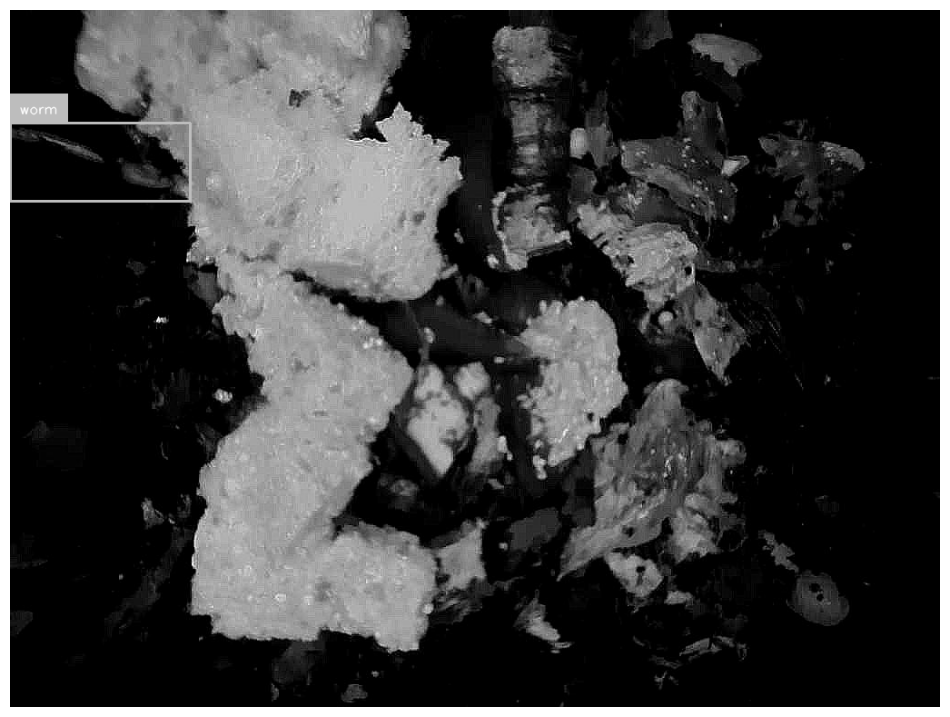

In [210]:
# Assuming selected_candidates is already defined
# Select a few images to display
sample_images = selected_candidates.sample(n=1)  # Adjust the number as needed

zip_file = sample_images.iloc[0]['zip_file']
image_file = sample_images.iloc[0]['image_file']

print(zip_file, image_file)

# Temporary directory to extract images
show_bounding_boxes(image_file, zip_file)